### **Analyse du modèle avec LIME**

[Github](https://github.com/marcotcr/lime)  
[Papier](https://arxiv.org/pdf/1602.04938.pdf)

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
data_dir = '../../data/images/all'
model_dir = '../../data/model'

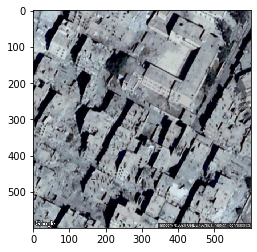

In [3]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image(os.path.join(data_dir, 'test',
                             '1', 'ezzor_0809.jpg'))
plt.imshow(img)
plt.show()

Importation du modèle avec output 0/1

--------------

--------------

In [4]:
# resize and take the center part of image to what our model expects
def get_input_transform():   
    transf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [5]:
get_input_tensors(img).shape

torch.Size([1, 3, 600, 600])

In [6]:
model = models.resnet50(pretrained=False, progress=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model_path = os.path.join(model_dir, 'all_model_81_stat_dict.pt')
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [7]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [8]:
probs = F.softmax(logits, dim=1)
probs = probs.detach().numpy()

In [9]:
def get_pil_transform(): 
    transf = transforms.Compose([
    ])    

    return transf

def get_preprocess_transform():    
    transf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [10]:
def batch_predict(images):
    results = np.empty(len(images)*2, dtype=np.float32).reshape(len(images), 2)
    model.eval()
    
    for i in range(len(images)):
        batch = preprocess_transform(images[i]).unsqueeze(0)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        batch = batch.to(device)
        logits = model(batch)               
        probs = F.softmax(logits, dim=1)
        results[i] = probs.detach().cpu().numpy()[0]
                      
    return results

In [11]:
test_pred = batch_predict([img, img])
test_pred.squeeze().argmax()

1

In [12]:
batch_predict([pill_transf(img), pill_transf(img)])

array([[0.0365543, 0.9634457],
       [0.0365543, 0.9634457]], dtype=float32)

In [13]:
from lime import lime_image

La fonction que l'on va utiliser venir faire une analyse sur les images perturbée

[explain_instance](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_image.LimeImageExplainer.explain_instance)

In [14]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image=np.array(pill_transf(img)), 
                                         classifier_fn=batch_predict, # classification function
                                         labels=(1, 0), 
                                         hide_color=0, 
                                         num_samples=10000) # number of images that will be sent to classification function

In [15]:
from skimage.segmentation import mark_boundaries

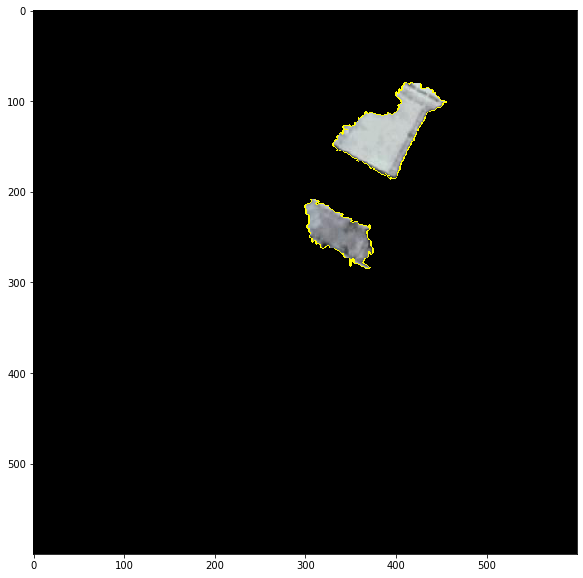

In [16]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True,
                                            num_features=2, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.figure(figsize=(10, 10))
plt.imshow(img_boundry1)

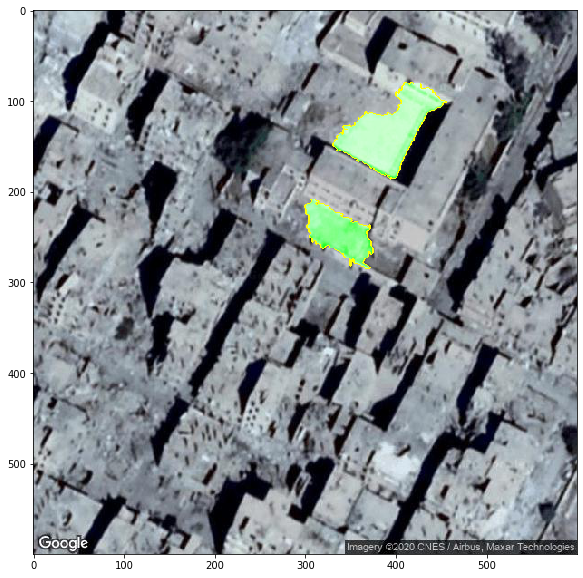

In [17]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,
                                            num_features=2, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.figure(figsize=(10, 10))
plt.imshow(img_boundry2)

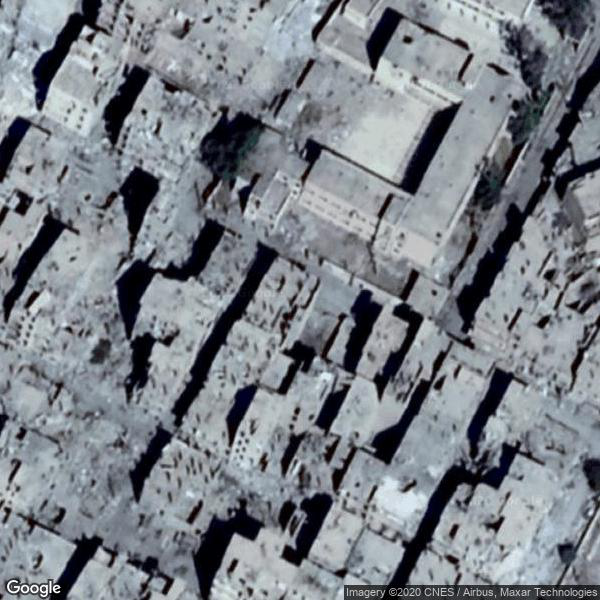

In [19]:
img

### **Autre exemple d'image contenant des batiments détruits**

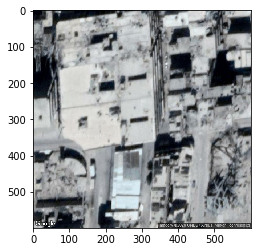

In [20]:
img = get_image(os.path.join(data_dir, 'test',
                             '1', 'alep_2329.jpg'))
plt.imshow(img)
plt.show()

In [21]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image=np.array(pill_transf(img)), 
                                         classifier_fn=batch_predict, # classification function
                                         labels=(1, 0), 
                                         hide_color=0, 
                                         num_samples=10000) # number of images that will be sent to classification function

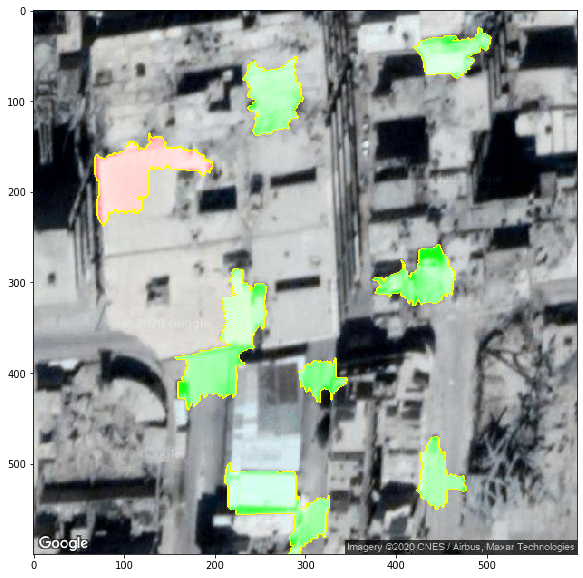

In [30]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,
                                            num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.figure(figsize=(10, 10))
plt.imshow(img_boundry2)

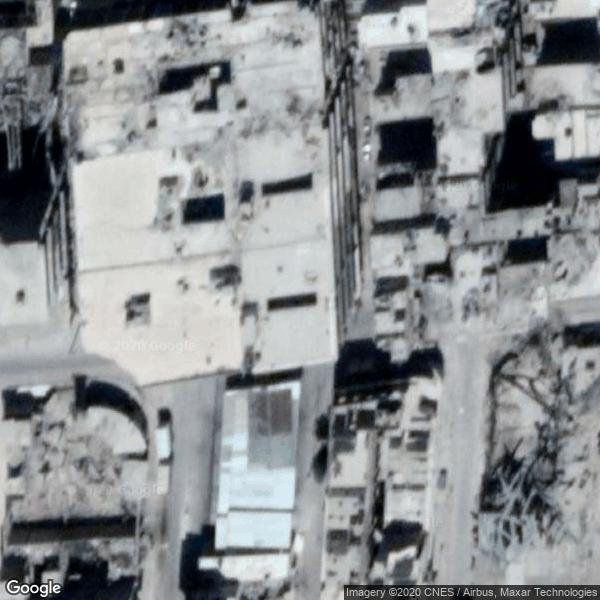

In [23]:
img

### **Image contenant des batiments détruits sur la base train Ezzor**

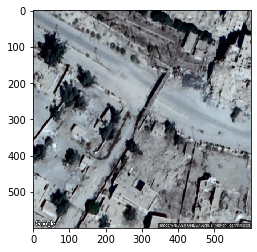

In [32]:
img = get_image(os.path.join(data_dir, 'train',
                             '1', 'ezzor_1152.jpg'))
plt.imshow(img)
plt.show()

In [47]:
batch_predict([img]), batch_predict([img]).squeeze().argmax()

(array([[0.45736447, 0.5426355 ]], dtype=float32), 1)

In [33]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image=np.array(pill_transf(img)), 
                                         classifier_fn=batch_predict, # classification function
                                         labels=(1, 0), 
                                         hide_color=0, 
                                         num_samples=5000) # number of images that will be sent to classification function

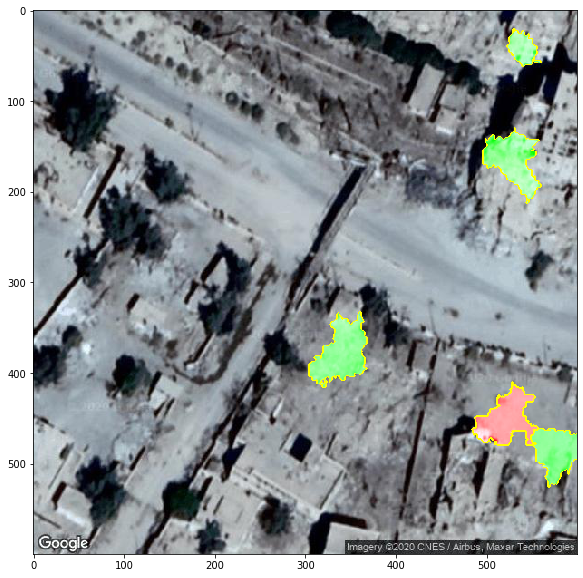

In [42]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,
                                            num_features=5, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.figure(figsize=(10, 10))
plt.imshow(img_boundry2)

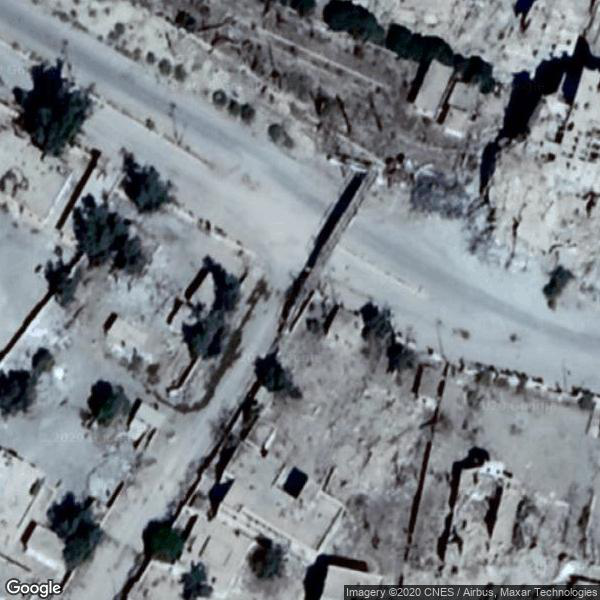

In [35]:
img

### **Image contenant des batiments détruits sur la base train Ezzor**

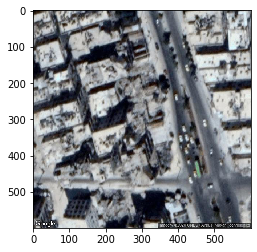

In [48]:
img = get_image(os.path.join(data_dir, 'train',
                             '1', 'alep_1484.jpg'))
plt.imshow(img)
plt.show()

In [50]:
batch_predict([img]), batch_predict([img]).squeeze().argmax()

(array([[0.3169338 , 0.68306625]], dtype=float32), 1)

In [49]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image=np.array(pill_transf(img)), 
                                         classifier_fn=batch_predict, # classification function
                                         labels=(1, 0), 
                                         hide_color=0, 
                                         num_samples=5000) # number of images that will be sent to classification function

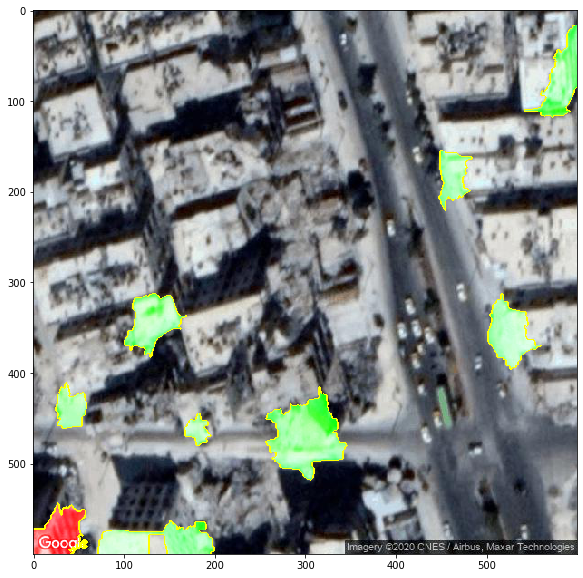

In [58]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,
                                            num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.figure(figsize=(10, 10))
plt.imshow(img_boundry2)

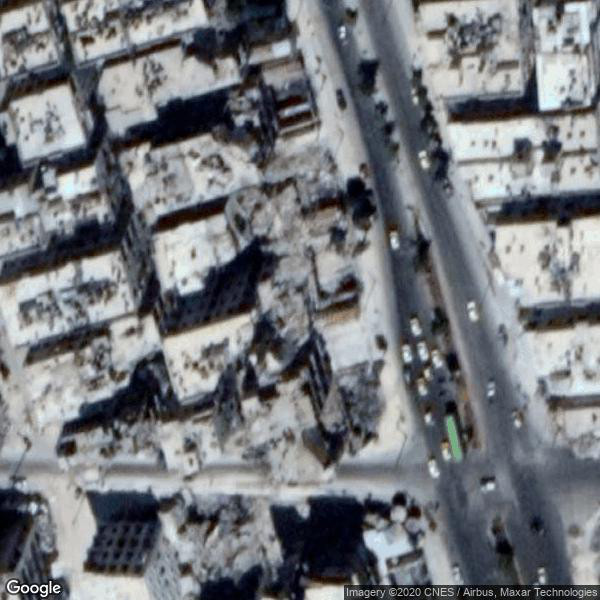

In [52]:
img